In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from argparse import Namespace

In [32]:
class Statistics:
    def __init__(self):
        self.metrics = dict()

    def update(self, metric_name, new_value):
        if metric_name in self.metrics:
            values = self.metrics[metric_name]
            values.append(new_value)

        else:
            values = [new_value]
            self.metrics.update({metric_name : values})

    def get_metric(self, metric_name):
        return self.metrics.get(metric_name)
    
    def epoch_count(self, metric_name = None):
        # MAX number of epoch in metrics
        if metric_name is None:
            max = 0
            for val in self.metrics.values():
                if len(val) > max:
                    max = len(val)

            return max 

        # Epoch count for metric name
        else:
            if metric_name in self.metrics:
                return len(self.metrics[metric_name])
            else: 
                return 0
     
    # First epoch is 0
    def epoch_metrics(self, epoch_num):
        result = dict()
        
        for metric_name, values in self.metrics.items():
            if (epoch_num >= 0) and (epoch_num < len(values)):
                metric_val = values[epoch_num]
                result.update({metric_name : metric_val})

        return result
    
    def metric_average(self, metric_name):
        if metric_name in self.metrics:
            values = self.metrics[metric_name]
            return float(sum(values) / len(values))
        
        else: 
            return None

In [33]:
def pixel_accuracy(prediction, mask):
    with torch.no_grad():
        pixel_count = float(mask.numel())

        prediction = torch.argmax(torch.softmax(prediction, dim=1), dim=1)
        correct = torch.eq(prediction, mask).int()

        accuracy = float(correct.sum()) / pixel_count

    return accuracy

def IoU(prediction, mask):
    pass

def dice(prediction, mask):
    pass

In [34]:
class Trainer:
    def __init__(self, config: Namespace, model: nn.Module):

        # Config and its parameters
        try:
            lrate = config.learning_rate
            (beta1, beta2) = config.betas
            wd = config.weight_decay
            self.batch_size = config.batch_size
        except AttributeError as e:
            raise Exception(f'Parameter "{e.name}" NOT found!')

        # Select GPU device
        self.device = (
            "cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu"
        )
        print(f"Using {self.device} device for training")

        # Move model to available device
        self.network = model.to(self.device)

        # Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate, betas=(beta1, beta2), weight_decay=wd)

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Statistics (metrics for each epoch)
        self.stats = Statistics()

    # Create Data Loaders
    def load_dataset(self, train_data, val_data, test_data):
        self.train_data = DataLoader(train_data, batch_size= self.batch_size, shuffle= True)
        self.val_data = DataLoader(val_data, batch_size= self.batch_size, shuffle= True)
        self.test_data = DataLoader(test_data, batch_size= self.batch_size, shuffle= False)

    # Forward Pass - create prediction and return its error (loss)
    def forward_pass(self, input, ground_truth):
        prediction = self.model(input)
        loss = self.loss_fn(prediction, ground_truth)
        return loss
    
    # Backward Pass - update parameters (weights, bias)
    def backward_pass(self, loss_value):
        self.optimizer.zero_grad()
        loss_value.backward()
        self.optimizer.step()

    def train(self, logger = None):
        self.model.train()

        # Train model on each dataset batch (train_data)
        for x, y in self.train_data:
            x, y = x.to(self.device), y.to(self.device)

            loss = self.forward_pass(x, y)

            # Save batch loss
            self.stats.update("train_loss", loss)

            self.backward_pass(loss)
        
    def evaluate(self):
        self.model.eval()

        with torch.no_grad():
            for x, y in self.val_data:
                x, y = x.to(self.device), y.to(self.device)

                loss = self.forward_pass(x, y)

                # Save batch loss
                self.stats.update("val_loss", loss)

    def test_model(self):
        self.model.eval()

        with torch.no_grad():
            for x, y in self.test_data:
                x, y = x.to(self.device), y.to(self.device)

                pred = self.model(x)

                # TODO - add metrics
                
    


In [35]:
# path_images = tensor_images.pt
# path_labels = tensor_labels.pt

class Lizard_dataset(Dataset):
    def __init__(self, path_images, path_labels):
        self.images = []
        self.labels = []
        self.transform = T.ToPILImage()

        # Load images and labels as tensors to cpu (moved to gpu during training)
        self.images = torch.load(path_images, map_location="cpu")
        self.labels = torch.load(path_labels, map_location="cpu")

        img_count = self.images.size(dim=0)
        num_channels = self.images.size(dim=1)
        height = self.images.size(dim=2)
        width = self.images.size(dim=3)

        img_count2 = self.labels.size(dim=0)
        height2 = self.labels.size(dim=1)
        width2 = self.labels.size(dim=2)

        if ( img_count != img_count2 or 
            height != height2 or 
            width != width2):

            print("Wrong tensor shapes!")
            print (f"- Images tensor shape : '{self.labels.shape}'")
            print (f"- Labels tensor shape : '{self.labels.shape}'")
        
    def __len__(self):
        return self.images.size(dim=0)

    def __getitem__(self, idx):
        image = self.images[idx, :, :, :]
        label = self.labels[idx, :, :]

        image = torch.unsqueeze(image, dim= 0)
        label = torch.unsqueeze(label, dim= 0)

        return (image, label)
    
    def show_imgLabel(self, idx):
        img_t, label_t = self.__getitem__(idx)

        img_t = torch.squeeze(img_t)
        image = self.transform(img_t)

        label_t = torch.squeeze(label_t)
        heatmap = self.transform(label_t)
     
        # Show image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f'Original Image  with index = {idx}')
        plt.axis('off')
        plt.show()

        

        # show segmentation
        num_classes = torch.unique(label_t)
        mycmap = plt.cm.get_cmap('tab10', num_classes.size(dim=0))

        plt.figure(figsize=(8, 8))
        plt.imshow(heatmap, cmap=mycmap, interpolation='nearest')
        plt.colorbar(label='Nucleus Class')
        plt.title('Segmentation Heatmap')
        plt.axis('off')
        plt.show()

    def show_tensorImg(self, t):
        t = torch.squeeze(t)
        img = self.transform(t)
        plt.show(img)
        #img.show() 

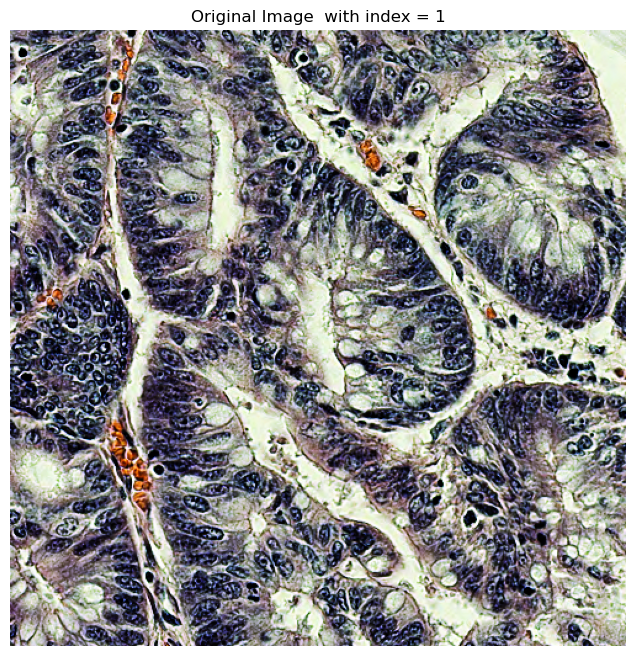

C:\Users\matul\AppData\Local\Temp\ipykernel_20308\2189720730.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mycmap = plt.cm.get_cmap('tab10', num_classes.size(dim=0))


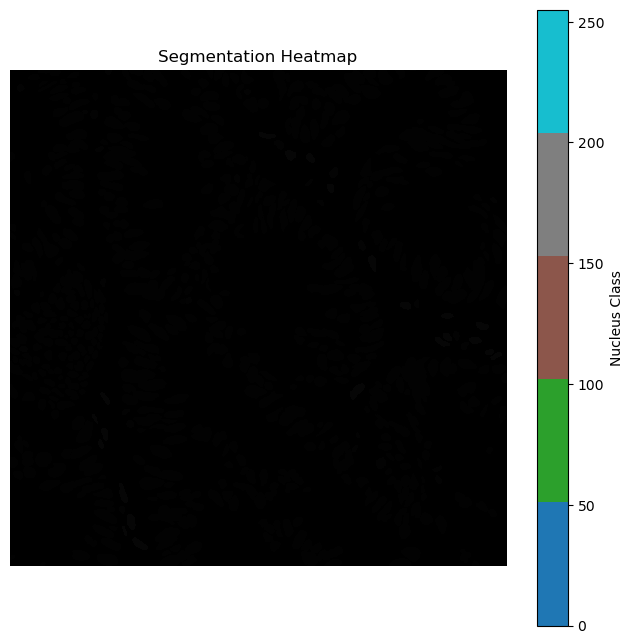

In [36]:
import net_config as cfg

x = torch.load('tensor_images.pt')
y = torch.load('tensor_labels.pt')

#print(x.shape)
#print(y.shape)

data = Lizard_dataset("tensor_images.pt", "tensor_labels.pt")

data.show_imgLabel(1)

#print(y)

#print(cfg.config_Unet)

#t = Trainer(cfg.config_Unet, None)